# SGD fit tests

In [372]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys
sys.path.append("../src")

from stochastic_glv_generator import *
from experiments import *
from analysis import *
from inference import *

In [373]:
n = 2
seed = 12345
r_max = 1.
A_diag_std = 2.
A_off_diag_std = 1.

p = sort_glv_params(n, seed, r_max, A_diag_std, A_off_diag_std)
r = p[:n]
A = p[n:].reshape((n, n))
x_eq = -np.linalg.inv(A)@r
print(x_eq)

env_noise = 0.0
t0 = 0
dt = 1e-2

np.random.seed(123)
init_perturb = np.random.choice([-1., 1.], n)
# init_perturb = -np.ones(n)
init_perturb[init_perturb<0] *= np.random.uniform(0.99, 1., (init_perturb<0).sum())
init_perturb[init_perturb>0] *= np.random.uniform(0.8, 5, (init_perturb>0).sum())
# perturb_scale_list = np.array([0.3, 0.5, 0.8, 1.])
perturb_scale_list = np.random.uniform(0, 1, 1)
t_samp_list = np.linspace(0, 20, 5).reshape((1,-1))
# t_samp_list = np.arange(0, 20+dt, dt)
meas_noise_list = np.array([0.05])
repetitions = 1

replicates = gen_replicates(p, env_noise, init_perturb, perturb_scale_list, t0, dt, t_samp_list, meas_noise_list, repetitions, seed=0, scale_meas_noise_by_abund=True)

[0.33151878 0.42426662]
1/1                                                                                                 

In [374]:
add_time_diff(replicates)
add_log_time_diff(replicates)

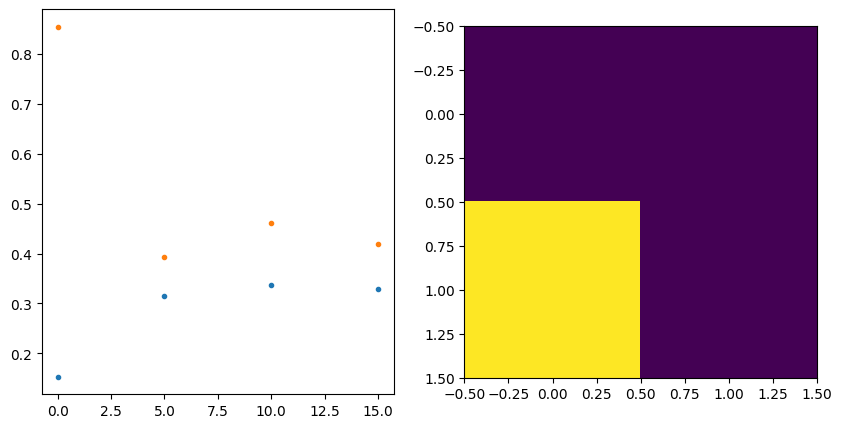

In [375]:
t = replicates.dropna()["time"].values
y = replicates.dropna()[[i for i in replicates.columns if i[:2]=="sp"]].values
dydt = replicates.dropna()[[i for i in replicates.columns if i[:3]=="dsp"]].values
dlogydt = replicates.dropna()[[i for i in replicates.columns if i[:6]=="dlogsp"]].values

plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t, y, ".")
plt.subplot(1, 2, 2)
plt.imshow(np.sign(A))
plt.show()

alpha = 1e-3
gamma = 0.9
eps = 1e-7
Eg2 = np.zeros_like(p)

n_steps = 10000
plot_steps = 1000

np.random.seed(2)
p2 = np.random.normal(0, 1, n*(n+1))
# p2 = p * np.random.normal(1, 0., p.shape[0])

p_hist2 = np.zeros((n_steps, p2.shape[0]))
p_hist2[0] = p2

mse_hist = np.zeros(n_steps)

batch_size = 1000

for i in range(n_steps):
    
    Eg2 *= 0.
    
    mse_hist[i] = mse(glv_time(t, y, p2), dydt)
    
    p2, Eg2 = mini_batch_sgd_rmsprop(replicates, p2, alpha, gamma, eps, Eg2, batch_size, averaging="none")
    p_hist2[i] = p2
    
    print("\r", " "*100, end="")
    print("\r"+f"{i}/{n_steps}: MSE = {mse_hist[i]:.10f}", end="")
    
    if i % plot_steps == 0:
        
        sol = euler_maruyama(glv, t[0], y[0], p2, 0., dt, t)

        plt.subplots(1, 3, figsize=(10, 3))
        plt.subplot(1, 3, 1)
        plt.plot(mse_hist[:i])
        plt.yscale("log")
        plt.subplot(1, 3, 2)        
        plt.plot(t, y)
        plt.plot(t, sol)
        plt.subplot(1, 3, 3)
        plt.imshow(np.sign(p2[n:].reshape((n,n))))
        plt.show()
        
plt.subplots(1, 3, figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.plot(mse_hist[:i])
plt.yscale("log")
plt.subplot(1, 3, 2)        
plt.plot(t, y)
plt.plot(t, sol)
plt.subplot(1, 3, 3)
plt.imshow(np.sign(p2[n:].reshape((n,n))))
plt.show()

0.5


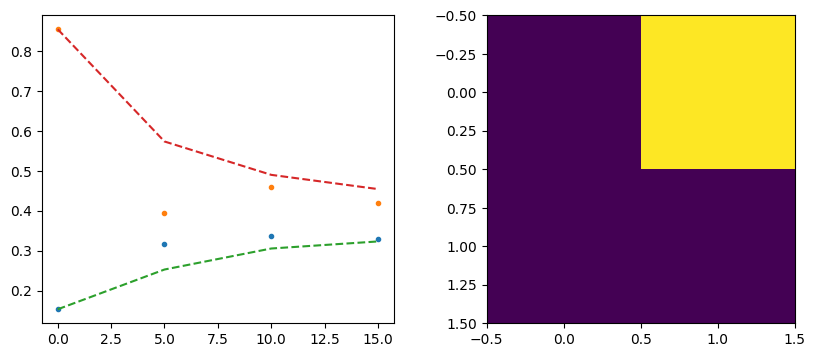

In [376]:
preg = fit_ridge_cv(replicates)
preg = np.concatenate((preg[0], preg[1].flatten()))

sol_reg = euler_maruyama(glv, t[0], y[0], preg, 0., dt, t)
plt.subplots(1, 2, figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(t, y, ".")
plt.plot(t, sol_reg, "--")
plt.subplot(1, 2, 2)
plt.imshow(np.sign(preg[n:].reshape((n,n))))

print((np.sign(preg[n:])==np.sign(p[n:])).sum()/n**2)

In [496]:
from scipy.optimize import curve_fit

def glv_fit(x, *p):
    n = x.shape[0]
    r = np.array(p[:n])
    A = np.array(p[n:]).reshape((n, n))
    
    rhs = x * (r + np.dot(A, x))

    return rhs


def glv_fit2(x, *p):
    n = int((np.sqrt(1+4*len(p))-1)/2)

    x_= x.reshape(len(x)//n, n)

    r = np.array(p[:n])
    A = np.array(p[n:]).reshape((n, n))
    
    rhs = x_ * (r + np.dot(x_, A.T))

    return rhs.flatten()

In [497]:
p3 = np.random.normal(p, 0.01, (10000, n*(n+1)))
p4 = np.zeros_like(p3)

for i in tqdm(range(len(p3))):
    p4[i] = curve_fit(glv_fit2, y.flatten(), dydt.flatten(), p3[i])[0]

100%|██████████| 10000/10000 [00:06<00:00, 1505.31it/s]


0.5


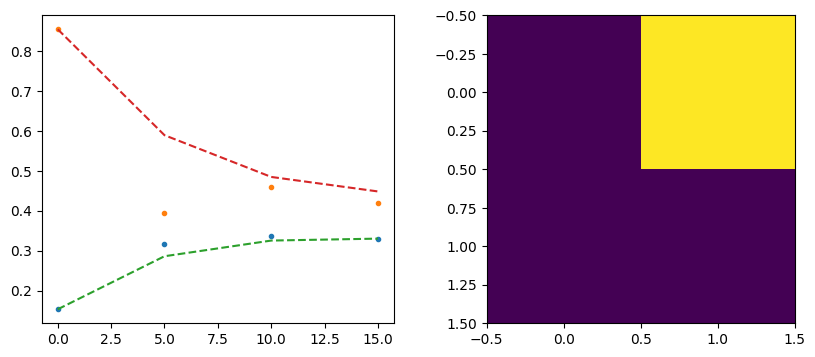

In [498]:
sol3 = euler_maruyama(glv, t[0], y[0], p4.mean(0), 0., dt, t)
plt.subplots(1, 2, figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(t, y, ".")
plt.plot(t, sol3, "--")
plt.subplot(1, 2, 2)
plt.imshow(np.sign(p4.mean(0)[n:].reshape((n,n))))

print((np.sign(p4.mean(0)[n:])==np.sign(p[n:])).sum()/n**2)

In [408]:
mse(glv_fit2(y.flatten(), *p), dydt.flatten())

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(StarArgUniTuple(float64 x 6), slice<a:b>)
 
There are 22 candidate implementations:
   - Of which 22 did not match due to:
   Overload of function 'getitem': File: <numerous>: Line N/A.
     With argument(s): '(StarArgUniTuple(float64 x 6), slice<a:b>)':
    No match.

During: typing of intrinsic-call at /tmp/ipykernel_265952/1916689204.py (7)

File "../../../../../../tmp/ipykernel_265952/1916689204.py", line 7:
<source missing, REPL/exec in use?>

During: resolving callee type: type(CPUDispatcher(<function glv_fit at 0x7fc546ffba60>))
During: typing of call at /tmp/ipykernel_265952/1916689204.py (19)

During: resolving callee type: type(CPUDispatcher(<function glv_fit at 0x7fc546ffba60>))
During: typing of call at /tmp/ipykernel_265952/1916689204.py (19)


File "../../../../../../tmp/ipykernel_265952/1916689204.py", line 19:
<source missing, REPL/exec in use?>


In [402]:
mse(glv_fit2(y.flatten(), *preg), dydt.flatten())

0.0002200546803477289

In [403]:
mse(glv_fit2(y.flatten(), *p4[0]), dydt.flatten())

1.7509881550332685e-06

In [404]:
mse(euler_maruyama(glv, t[0], y[0], p, 0., dt, t), y)

0.00020842285354604324

In [405]:
mse(euler_maruyama(glv, t[0], y[0], preg, 0., dt, t), y)

0.0049534850357034615

In [406]:
mse(euler_maruyama(glv, t[0], y[0], p4[0], 0., dt, t), y)

0.005109423256873174

/tmp/ipykernel_265952/2928885897.py:5: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(F))


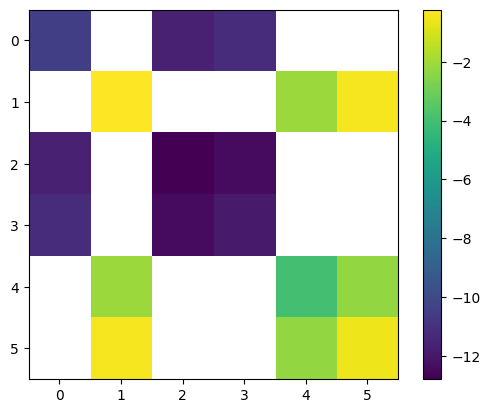

In [386]:
S = np.expand_dims(glv_time(t, y, p)-dydt, axis=-1)*glv_jac_time(t, y, p)
S = np.concatenate(S, 0)
F = S.T@S

plt.imshow(np.log(F))
plt.colorbar()

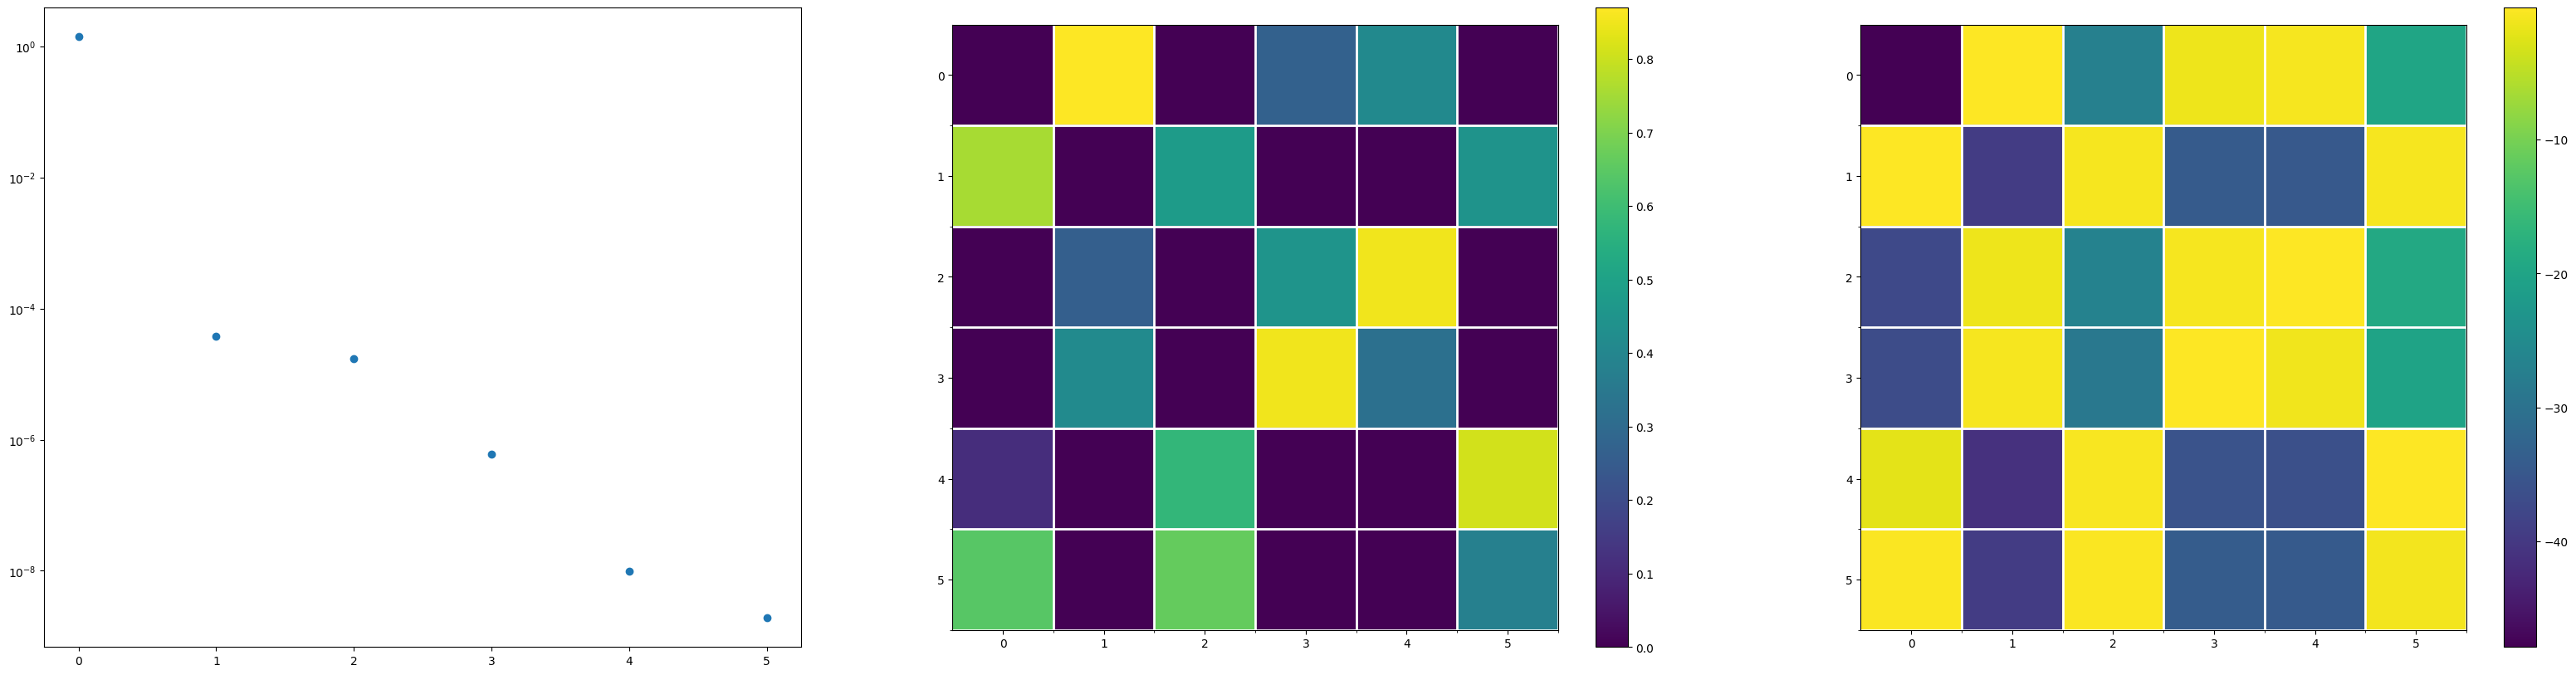

In [387]:
eigvals, eigvecs = np.linalg.eig(F)

eigvecs = eigvecs[:,np.argsort(eigvals)[::-1]]
eigvals = eigvals[np.argsort(eigvals)[::-1]]

plt.subplots(1, 3, figsize=(40,10))
plt.subplot(1, 3, 1)
plt.plot(eigvals, "o")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(eigvecs))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(eigvecs)))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.show()

/tmp/ipykernel_265952/3687873738.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(Freg))


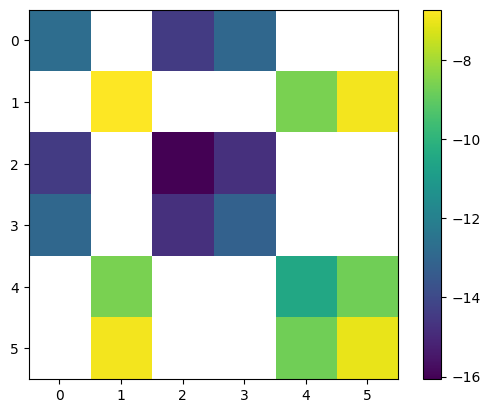

In [388]:
Sreg = np.expand_dims(glv_time(t, y, preg)-dydt, axis=-1)*glv_jac_time(t, y, preg)
Sreg = np.concatenate(Sreg, 0)
Freg = Sreg.T@Sreg
plt.imshow(np.log(Freg))
plt.colorbar()

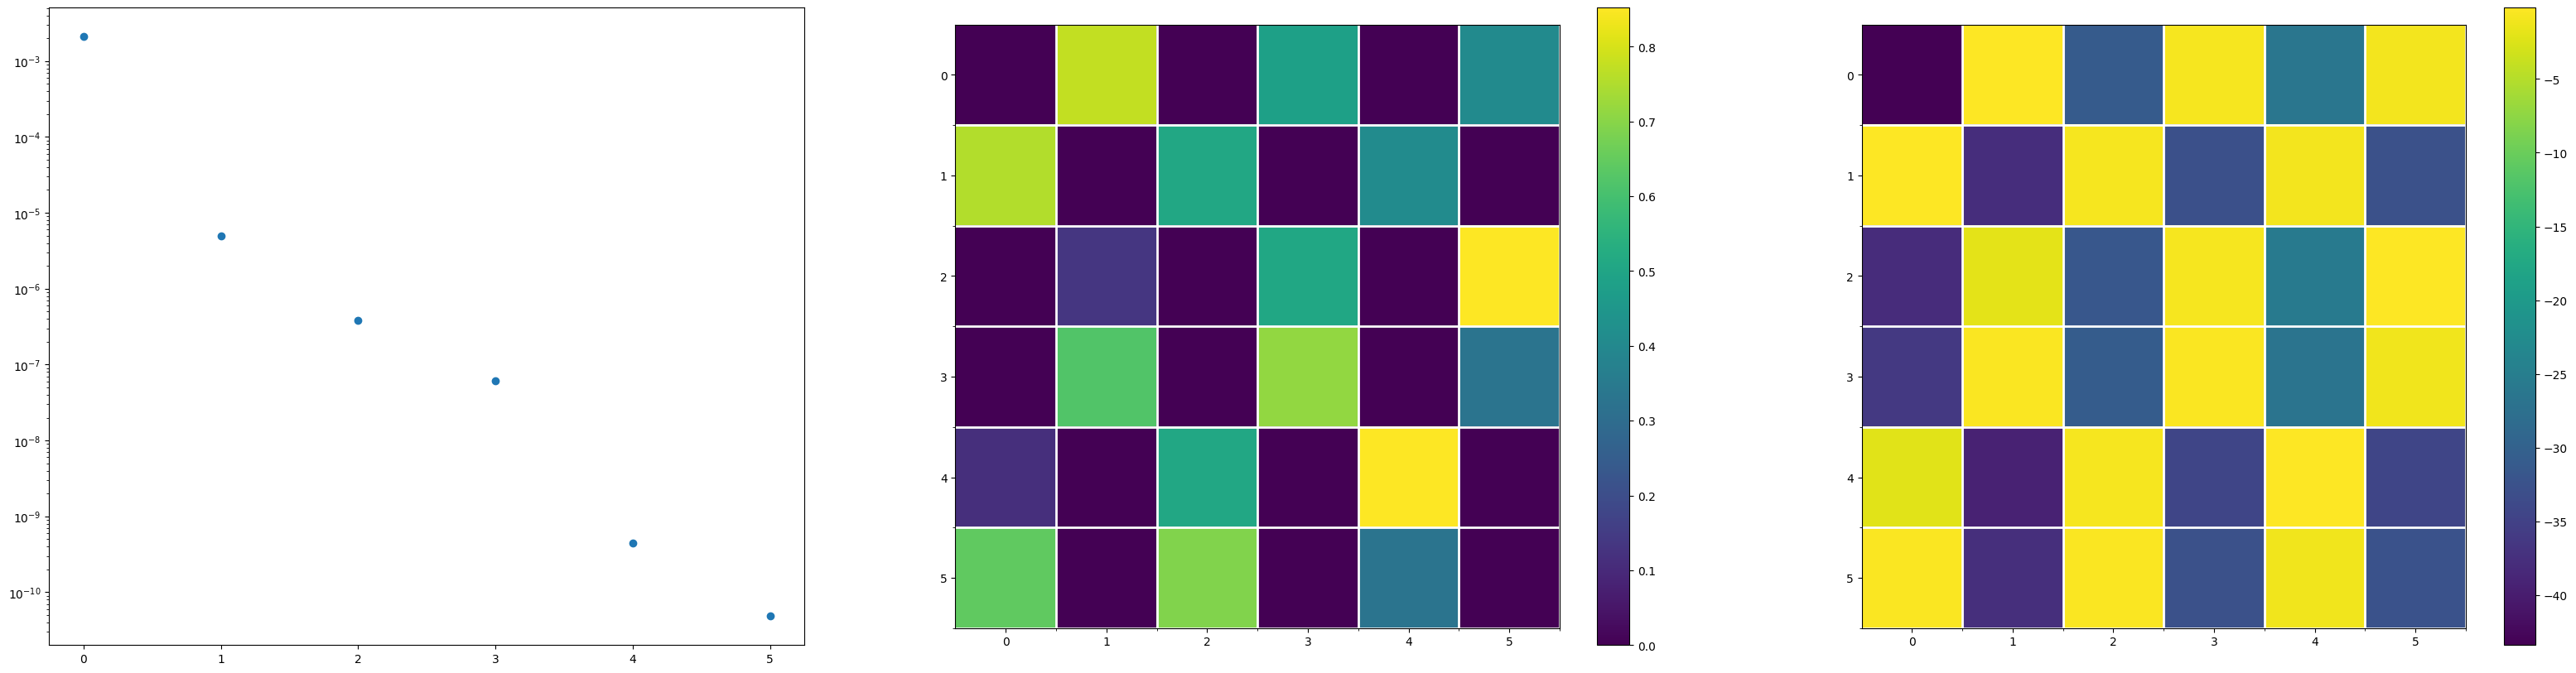

In [389]:
eigvals, eigvecs = np.linalg.eig(Freg)

eigvecs = eigvecs[:,np.argsort(eigvals)[::-1]]
eigvals = eigvals[np.argsort(eigvals)[::-1]]

plt.subplots(1, 3, figsize=(40,10))
plt.subplot(1, 3, 1)
plt.plot(eigvals, "o")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(eigvecs))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(eigvecs)))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.show()

/tmp/ipykernel_265952/2967859735.py:4: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(F4))


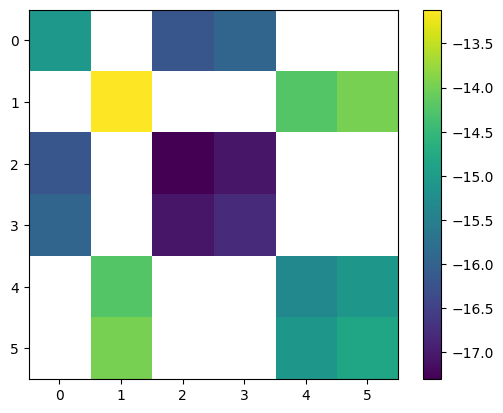

In [390]:
S4 = np.expand_dims(glv_time(t, y, p4[0])-dydt, axis=-1)*glv_jac_time(t, y, p4[0])
S4 = np.concatenate(S4, 0)
F4 = S4.T@S4
plt.imshow(np.log(F4))
plt.colorbar()

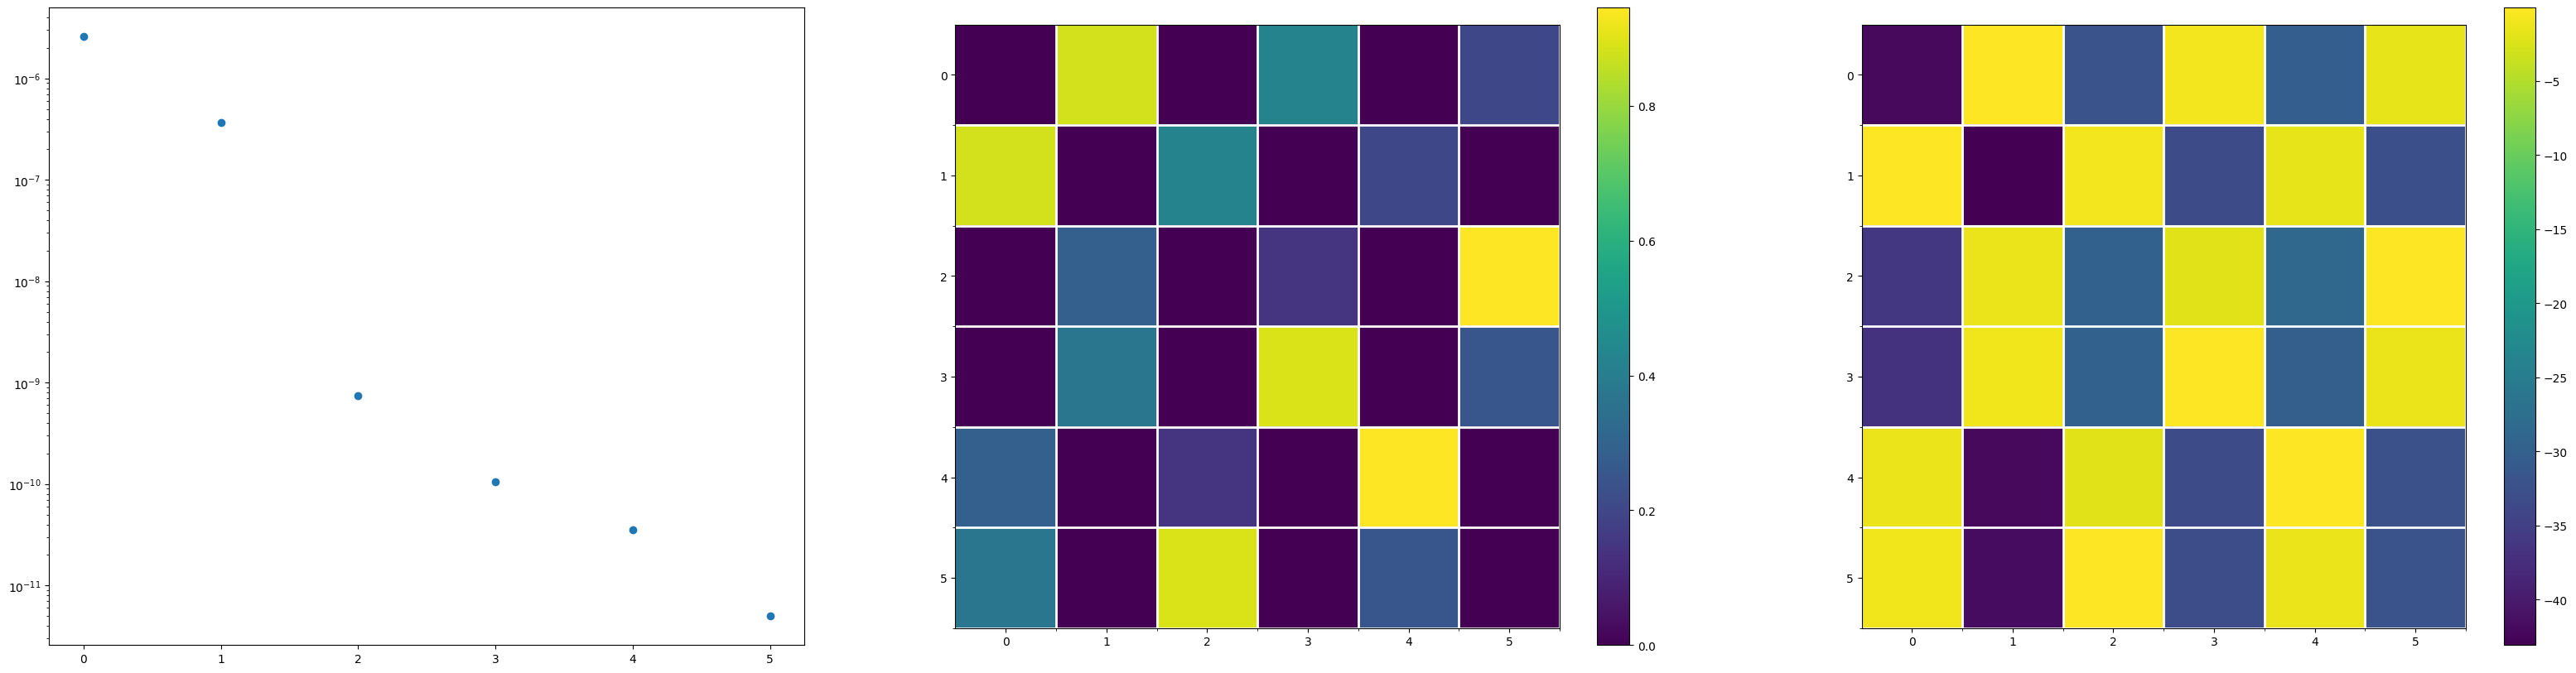

In [391]:
eigvals, eigvecs = np.linalg.eig(F4)

eigvecs = eigvecs[:,np.argsort(eigvals)[::-1]]
eigvals = eigvals[np.argsort(eigvals)[::-1]]

plt.subplots(1, 3, figsize=(40,10))
plt.subplot(1, 3, 1)
plt.plot(eigvals, "o")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.imshow(np.abs(eigvecs))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(eigvecs)))
plt.colorbar()
plt.xticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.yticks(np.arange(0.5, n*(n+1), 1), minor=True)
plt.grid(which="minor", color="w", lw=2)
plt.show()

In [392]:
np.abs(F-Freg).sum()

3.221111618726175

In [393]:
np.abs(F-F4).sum()

3.2259304274548555

In [394]:
p[n:].reshape((n,n))

array([[-2.09290788, -0.5557303 ],
       [ 1.96578057, -2.28174615]])

In [395]:
preg[n:].reshape((n,n))

array([[-0.76761545,  0.02196789],
       [-0.45296193, -0.55553298]])

In [396]:
p4[0][n:].reshape((n,n))

array([[-1.04897906,  0.06646765],
       [-0.67040119, -0.53652717]])

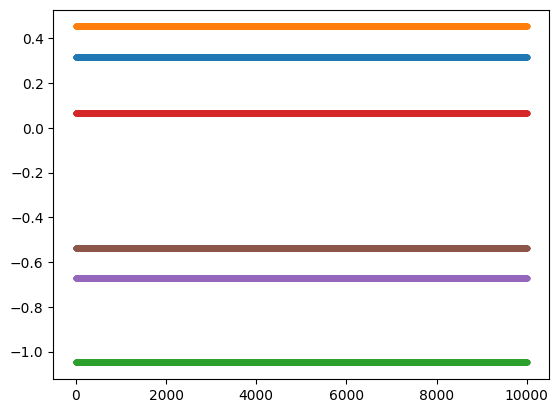

In [400]:
plt.plot(p4, ".")

In [398]:
mse(sol_reg, y)

0.0049534850357034615

In [399]:
mse(sol3, y)

0.005109423196627472